# TensorFlow VGG16 → ONNX Conversion

Chuyển đổi model **VGG16** từ TensorFlow/Keras sang ONNX format và benchmark performance trên CPU/GPU.

## Model Information
- **Framework**: TensorFlow/Keras
- **Model**: VGG16 (ImageNet pre-trained)
- **Input**: 224x224x3 RGB images
- **Output**: 1000 classes

## Workflow
1. Load pre-trained VGG16 from Keras
2. Convert to ONNX using tf2onnx
3. Validate ONNX model
4. Benchmark on CPU
5. Benchmark on GPU (if available)
6. Compare performance

## 1. Setup Environment

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [2]:
!pip install -q onnx onnxruntime-gpu onnxsim>=0.1.71 onnxscript
!pip install -q tensorflow tf2onnx
!pip install -q matplotlib seaborn pandas pillow numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 131.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 17.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.


## 2. Import Libraries

In [3]:
import tensorflow as tf
from tensorflow import keras
import onnx
import onnxruntime as ort
import tf2onnx
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Print versions
print(f'TensorFlow version: {tf.__version__}')
print(f'ONNX version: {onnx.__version__}')
print(f'ONNX Runtime version: {ort.__version__}')
print(f'GPU available (TF): {len(tf.config.list_physical_devices("GPU")) > 0}')
if len(tf.config.list_physical_devices("GPU")) > 0:
    print(f'GPU devices: {tf.config.list_physical_devices("GPU")}')
print(f'ONNX Runtime providers: {ort.get_available_providers()}')

TensorFlow version: 2.19.0
ONNX version: 1.17.0
ONNX Runtime version: 1.23.2
GPU available (TF): True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
ONNX Runtime providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


## 3. Create Directories

In [4]:
os.makedirs('models/tensorflow', exist_ok=True)
os.makedirs('results', exist_ok=True)
print('Directories created successfully!')
print(f'  - models/tensorflow/')
print(f'  - results/')

Directories created successfully!
  - models/tensorflow/
  - results/


## 4. Load Pre-trained VGG16

In [5]:
print('='*60)
print('Loading TensorFlow VGG16 (ImageNet pre-trained)')
print('='*60)

# Load VGG16 with ImageNet weights
vgg16_model = keras.applications.VGG16(
    weights='imagenet',
    include_top=True,
    input_shape=(224, 224, 3)
)

# Display model summary
print('\nModel Architecture:')
vgg16_model.summary()

print(f'\nModel input shape: {vgg16_model.input_shape}')
print(f'Model output shape: {vgg16_model.output_shape}')
print(f'Total parameters: {vgg16_model.count_params():,}')

Loading TensorFlow VGG16 (ImageNet pre-trained)
553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

Model Architecture:


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)


Model input shape: (None, 224, 224, 3)
Model output shape: (None, 1000)
Total parameters: 138,357,544


## 5. Test TensorFlow Inference

In [6]:
# Create dummy input (batch_size=1, height=224, width=224, channels=3)
dummy_input = np.random.randn(1, 224, 224, 3).astype(np.float32)

# Test inference
print('Testing TensorFlow inference...')
output = vgg16_model.predict(dummy_input, verbose=0)
print(f'Input shape: {dummy_input.shape}')
print(f'Output shape: {output.shape}')
print(f'Output sample: {output[0][:5]}')
print('✅ TensorFlow inference successful!')

Testing TensorFlow inference...
Input shape: (1, 224, 224, 3)
Output shape: (1, 1000)
Output sample: [0.00022917 0.00100419 0.00041814 0.00080205 0.0016776 ]
✅ TensorFlow inference successful!


## 6. Convert VGG16 to ONNX

In [7]:
print('='*60)
print('Converting TensorFlow VGG16 → ONNX')
print('='*60)

# Define output path
onnx_model_path = 'models/tensorflow/vgg16.onnx'

# Define input signature
input_signature = (tf.TensorSpec((1, 224, 224, 3), tf.float32, name='input'),)

# Convert to ONNX
model_proto, _ = tf2onnx.convert.from_keras(
    vgg16_model,
    input_signature=input_signature,
    opset=18,
    output_path=onnx_model_path
)

# Check model size
size_mb = os.path.getsize(onnx_model_path) / (1024 * 1024)
print(f'\n✅ ONNX model saved: {onnx_model_path}')
print(f'   Model size: {size_mb:.2f} MB')

Converting TensorFlow VGG16 → ONNX


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7b9380ce7880>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.



✅ ONNX model saved: models/tensorflow/vgg16.onnx
   Model size: 527.80 MB


## 7. Validate ONNX Model

In [8]:
print('='*60)
print('Validating ONNX Model')
print('='*60)

# Load and check ONNX model
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
print('✅ ONNX model is valid!')

# Display model info
print(f'\nONNX IR version: {onnx_model.ir_version}')
print(f'Producer name: {onnx_model.producer_name}')
print(f'Producer version: {onnx_model.producer_version}')
print(f'Opset version: {onnx_model.opset_import[0].version}')

# Display inputs
print('\nModel Inputs:')
for input_tensor in onnx_model.graph.input:
    shape = [d.dim_value for d in input_tensor.type.tensor_type.shape.dim]
    print(f'  - {input_tensor.name}: {shape}')

# Display outputs
print('\nModel Outputs:')
for output_tensor in onnx_model.graph.output:
    shape = [d.dim_value for d in output_tensor.type.tensor_type.shape.dim]
    print(f'  - {output_tensor.name}: {shape}')

Validating ONNX Model
✅ ONNX model is valid!

ONNX IR version: 8
Producer name: tf2onnx
Producer version: 1.16.1 15c810
Opset version: 18

Model Inputs:
  - input: [1, 224, 224, 3]

Model Outputs:
  - predictions: [1, 1000]


## 8. ONNX Inference Class

In [9]:
class ONNXInference:
    """ONNX Runtime Inference with CPU/GPU support"""

    def __init__(self, onnx_path: str, use_gpu: bool = True):
        # Select providers based on availability
        if use_gpu and 'CUDAExecutionProvider' in ort.get_available_providers():
            providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
            self.device = 'GPU'
        else:
            providers = ['CPUExecutionProvider']
            self.device = 'CPU'

        # Session options for optimization
        sess_options = ort.SessionOptions()
        sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

        # Create inference session
        self.session = ort.InferenceSession(
            onnx_path,
            providers=providers,
            sess_options=sess_options
        )

        # Get input/output metadata
        self.input_name = self.session.get_inputs()[0].name
        self.input_shape = self.session.get_inputs()[0].shape
        self.output_name = self.session.get_outputs()[0].name

        print(f'Model loaded: {os.path.basename(onnx_path)}')
        print(f'Device: {self.device}')
        print(f'Input: {self.input_name} {self.input_shape}')
        print(f'Output: {self.output_name}')

    def inference(self, input_data: np.ndarray):
        """Run inference on input data"""
        if input_data.dtype != np.float32:
            input_data = input_data.astype(np.float32)
        return self.session.run([self.output_name], {self.input_name: input_data})[0]

    def benchmark(self, input_data: np.ndarray, num_runs: int = 100, warmup: int = 10):
        """Benchmark inference performance"""
        # Warmup
        for _ in range(warmup):
            self.inference(input_data)

        # Benchmark
        times = []
        for _ in range(num_runs):
            start = time.time()
            self.inference(input_data)
            times.append(time.time() - start)

        # Calculate statistics
        mean_time = np.mean(times) * 1000  # Convert to ms
        std_time = np.std(times) * 1000
        fps = 1000.0 / mean_time

        return {
            'mean': mean_time,
            'std': std_time,
            'fps': fps,
            'min': np.min(times) * 1000,
            'max': np.max(times) * 1000,
            'device': self.device
        }

print('ONNXInference class defined successfully!')

ONNXInference class defined successfully!


## 9. Benchmark on CPU

In [10]:
print('='*60)
print('Benchmarking VGG16 on CPU')
print('='*60)

# Create dummy input
dummy_input = np.random.randn(1, 224, 224, 3).astype(np.float32)

# Load model on CPU
vgg16_cpu = ONNXInference(onnx_model_path, use_gpu=False)

# Run benchmark
print('\nRunning benchmark (100 iterations)...')
cpu_results = vgg16_cpu.benchmark(dummy_input, num_runs=100, warmup=10)

# Display results
print('\n' + '='*60)
print('CPU Benchmark Results')
print('='*60)
print(f'Mean inference time: {cpu_results["mean"]:.2f} ± {cpu_results["std"]:.2f} ms')
print(f'Min inference time:  {cpu_results["min"]:.2f} ms')
print(f'Max inference time:  {cpu_results["max"]:.2f} ms')
print(f'Throughput:          {cpu_results["fps"]:.2f} FPS')
print('='*60)

Benchmarking VGG16 on CPU
Model loaded: vgg16.onnx
Device: CPU
Input: input [1, 224, 224, 3]
Output: predictions

Running benchmark (100 iterations)...

CPU Benchmark Results
Mean inference time: 314.32 ± 66.53 ms
Min inference time:  267.33 ms
Max inference time:  635.30 ms
Throughput:          3.18 FPS


## 10. Benchmark on GPU (if available)

In [11]:
has_cuda = 'CUDAExecutionProvider' in ort.get_available_providers()

if has_cuda:
    print('='*60)
    print('Benchmarking VGG16 on GPU')
    print('='*60)

    # Load model on GPU
    vgg16_gpu = ONNXInference(onnx_model_path, use_gpu=True)

    # Run benchmark
    print('\nRunning benchmark (100 iterations)...')
    gpu_results = vgg16_gpu.benchmark(dummy_input, num_runs=100, warmup=10)

    # Display results
    print('\n' + '='*60)
    print('GPU Benchmark Results')
    print('='*60)
    print(f'Mean inference time: {gpu_results["mean"]:.2f} ± {gpu_results["std"]:.2f} ms')
    print(f'Min inference time:  {gpu_results["min"]:.2f} ms')
    print(f'Max inference time:  {gpu_results["max"]:.2f} ms')
    print(f'Throughput:          {gpu_results["fps"]:.2f} FPS')
    print('='*60)
else:
    print('⚠️  CUDA not available. Skipping GPU benchmark.')
    gpu_results = None

Benchmarking VGG16 on GPU
Model loaded: vgg16.onnx
Device: GPU
Input: input [1, 224, 224, 3]
Output: predictions

Running benchmark (100 iterations)...

GPU Benchmark Results
Mean inference time: 9.19 ± 0.95 ms
Min inference time:  8.74 ms
Max inference time:  13.82 ms
Throughput:          108.76 FPS


## 11. Performance Comparison

In [12]:
print('\n' + '='*80)
print('PERFORMANCE COMPARISON: TensorFlow VGG16 → ONNX Runtime')
print('='*80)

if has_cuda and gpu_results:
    # Calculate speedup
    speedup = cpu_results['mean'] / gpu_results['mean']

    print(f'{"Metric":<25} {"CPU":<20} {"GPU":<20} {"Speedup":<15}')
    print('-'*80)
    print(f'{"Inference Time (ms)":<25} {cpu_results["mean"]:<20.2f} {gpu_results["mean"]:<20.2f} {speedup:<15.2f}x')
    print(f'{"Throughput (FPS)":<25} {cpu_results["fps"]:<20.2f} {gpu_results["fps"]:<20.2f} {gpu_results["fps"]/cpu_results["fps"]:<15.2f}x')
    print(f'{"Min Time (ms)":<25} {cpu_results["min"]:<20.2f} {gpu_results["min"]:<20.2f} -')
    print(f'{"Max Time (ms)":<25} {cpu_results["max"]:<20.2f} {gpu_results["max"]:<20.2f} -')
    print('='*80)
    print(f'💡 GPU is {speedup:.2f}x faster than CPU')
else:
    print(f'{"Metric":<30} {"CPU":<15}')
    print('-'*50)
    print(f'{"Inference Time (ms)":<30} {cpu_results["mean"]:<15.2f}')
    print(f'{"Throughput (FPS)":<30} {cpu_results["fps"]:<15.2f}')
    print('='*50)


PERFORMANCE COMPARISON: TensorFlow VGG16 → ONNX Runtime
Metric                    CPU                  GPU                  Speedup        
--------------------------------------------------------------------------------
Inference Time (ms)       314.32               9.19                 34.19          x
Throughput (FPS)          3.18                 108.76               34.19          x
Min Time (ms)             267.33               8.74                 -
Max Time (ms)             635.30               13.82                -
💡 GPU is 34.19x faster than CPU


## 12. Visualization

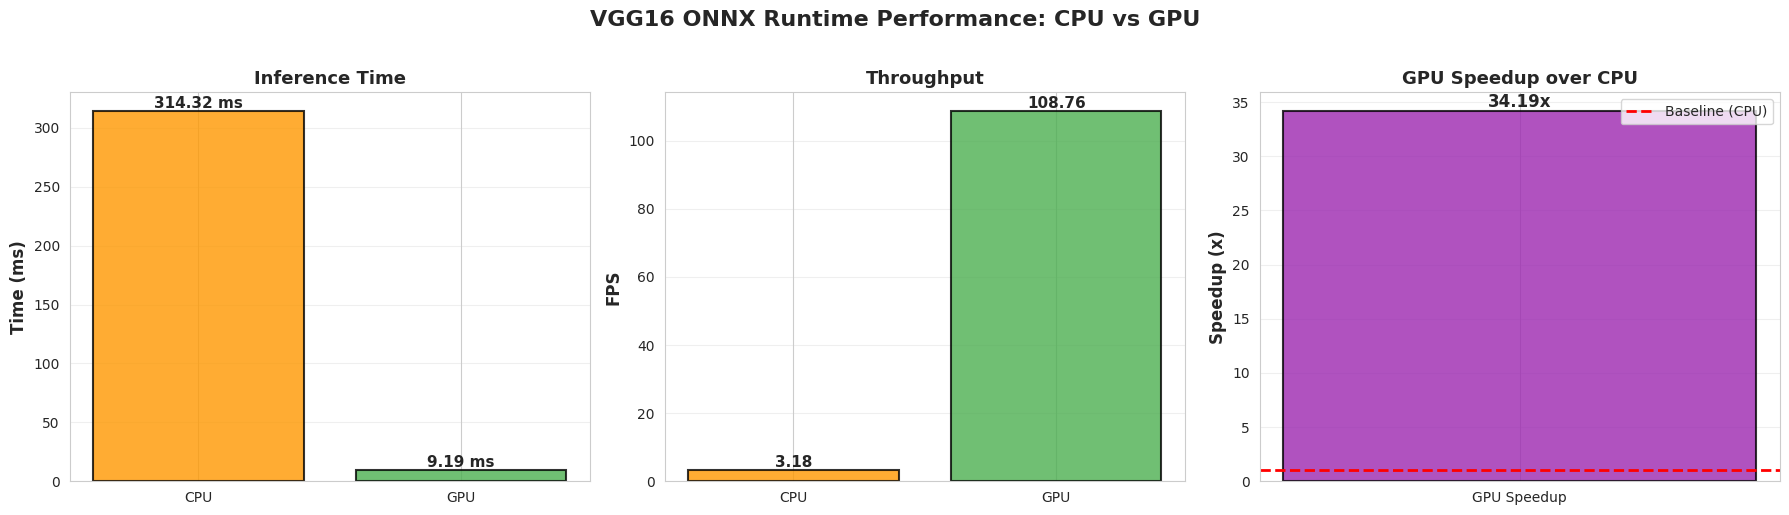


✅ Saved: results/vgg16_comparison.png


In [13]:
if has_cuda and gpu_results:
    # Create comparison plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('VGG16 ONNX Runtime Performance: CPU vs GPU',
                 fontsize=16, fontweight='bold', y=1.02)

    # 1. Inference Time
    devices = ['CPU', 'GPU']
    times = [cpu_results['mean'], gpu_results['mean']]
    colors = ['#FF9800', '#4CAF50']

    bars = axes[0].bar(devices, times, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
    axes[0].set_title('Inference Time', fontsize=13, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)

    for bar, time in zip(bars, times):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{time:.2f} ms', ha='center', va='bottom',
                    fontsize=11, fontweight='bold')

    # 2. Throughput
    fps_values = [cpu_results['fps'], gpu_results['fps']]
    bars = axes[1].bar(devices, fps_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[1].set_ylabel('FPS', fontsize=12, fontweight='bold')
    axes[1].set_title('Throughput', fontsize=13, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)

    for bar, fps in zip(bars, fps_values):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{fps:.2f}', ha='center', va='bottom',
                    fontsize=11, fontweight='bold')

    # 3. Speedup
    speedup = cpu_results['mean'] / gpu_results['mean']
    bar = axes[2].bar(['GPU Speedup'], [speedup], color='#9C27B0', alpha=0.8,
                      edgecolor='black', linewidth=1.5)
    axes[2].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Baseline (CPU)')
    axes[2].set_ylabel('Speedup (x)', fontsize=12, fontweight='bold')
    axes[2].set_title('GPU Speedup over CPU', fontsize=13, fontweight='bold')
    axes[2].legend()
    axes[2].grid(axis='y', alpha=0.3)

    height = bar[0].get_height()
    axes[2].text(bar[0].get_x() + bar[0].get_width()/2., height,
                f'{speedup:.2f}x', ha='center', va='bottom',
                fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig('results/vgg16_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('\n✅ Saved: results/vgg16_comparison.png')

else:
    # CPU-only plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('VGG16 ONNX Runtime Performance (CPU)',
                 fontsize=16, fontweight='bold', y=1.02)

    # Inference Time
    bar = axes[0].bar(['CPU'], [cpu_results['mean']], color='#FF9800',
                      alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
    axes[0].set_title('Inference Time', fontsize=13, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)

    height = bar[0].get_height()
    axes[0].text(bar[0].get_x() + bar[0].get_width()/2., height,
                f'{cpu_results["mean"]:.2f} ms', ha='center', va='bottom',
                fontsize=11, fontweight='bold')

    # Throughput
    bar = axes[1].bar(['CPU'], [cpu_results['fps']], color='#F44336',
                      alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[1].set_ylabel('FPS', fontsize=12, fontweight='bold')
    axes[1].set_title('Throughput', fontsize=13, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)

    height = bar[0].get_height()
    axes[1].text(bar[0].get_x() + bar[0].get_width()/2., height,
                f'{cpu_results["fps"]:.2f}', ha='center', va='bottom',
                fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig('results/vgg16_cpu_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('\n✅ Saved: results/vgg16_cpu_performance.png')